In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from time import time
from inspyred import ec, benchmarks
from copy import deepcopy
from typing import List, Dict
from collections import Counter

In [ ]:
class ACOWorkoutRoutine:
    def __init__(self, userLevel, equipment, requestMuscles, time, userID, exercises, num_ants, evaporation, alpha, beta, max_iterations):
        
        # Initial parameters (same as GA)
        self.userLevel = userLevel.lower()
        self.time = time  # hours

        self.length = time * 6  # max 6 exercises per hour
        self.equipment = equipment
        self.requestMuscles = requestMuscles
        self.userID = userID
        
        # ACO parameters
        self.num_ants = num_ants
        self.evaporation = evaporation  # Pheromone evaporation rate
        self.alpha = alpha  # Pheromone weight
        self.beta = beta   # Heuristic weight
        self.max_iterations = max_iterations
        self.pheromone = None
        
        # Difficulty mapping (same as GA)
        self.difficulty_map = {
            "beginner": 0, "novice": 1, "intermediate": 2,
            "advanced": 3, "expert": 4, "master": 5
        }

        # History
        self.pheromone_history = []
        self.trails_history = []
        self.best_fitness_history = []

        # Exercises
        self.exercises = exercises  # List of exercises
        self.exercises = self.clean_exercises(exercises)
        
    
    def clean_exercises(self, exercises):
        def clean_equipment(val):
            return str(val).strip().lower() if isinstance(val, str) else ''

        requested = {str(m).strip().lower() for m in self.requestMuscles}
        user_eq = {str(e).strip().lower() for e in self.equipment}
        has_gym = "gym" in user_eq

        valid_exercises = []
        for ex in exercises:
            if not ex:
                continue

            muscle = str(ex.get('TargetMuscleGroup', '')).strip().lower()
            primary = clean_equipment(ex.get('PrimaryEquipment'))
            secondary = clean_equipment(ex.get('SecondaryEquipment'))
            equipment_needed = {primary, secondary} - {''}

            # Skip if equipment is not available and user doesn't have gym access
            if not has_gym and not equipment_needed.issubset(user_eq):
                continue

            # Always include requested muscles
            if muscle in requested:
                valid_exercises.append(ex)
            else:
                if random.random() < 0.1:  # 10% chance for non-requested muscle
                    valid_exercises.append(ex)

        # Re-index the filtered exercises
        for idx, exercise in enumerate(valid_exercises):
            exercise['Index'] = idx

        """  
       print("[DEBUG] Final valid exercises:")
        for ex in valid_exercises:
            print(f"  Muscle: {ex['TargetMuscleGroup']}, Primary: {ex.get('PrimaryEquipment')}, Secondary: {ex.get('SecondaryEquipment')}")
            """
        return valid_exercises

    def initialize_pheromone(self):
        """Initialize the pheromone matrix with small values"""
        num_exercises = len(self.exercises)
        self.pheromone = np.ones((num_exercises, num_exercises)) * 0.1
    
    def evaluate(self, candidate):
        """Evaluation function (same as GA)"""
        routine = self.get_exercises(candidate)
        n = len(routine)

        y_penalties = self.repetition_penalties(candidate)
        y_factor = sum(y_penalties) / n
        muscles_factor = self.trained_muscles(routine)
        difficulty_factor = self.difficulty_score(routine)
        if not self.equipment == ["Gym"]:
            equipment_factor = self.used_equipment(routine)
        else:
            equipment_factor = 1  # si es gym, no penaliza por equipo

        
        value = 100 * y_factor * muscles_factor * difficulty_factor * equipment_factor
        
        if value < 100:
            bonus = self.calculate_bonus(routine)
            value = min(value + bonus, 100)
            
        return value
    
    def heuristic(self, prev_exercise, next_exercise):
        """Heuristic function that estimates the goodness of choosing next_exercise after prev_exercise"""
        # Penalty for close repetition
        repetition_penalty = 0.95 if prev_exercise == next_exercise else 1.0
        
        # Muscle group diversity
        muscle_diversity = 1.0
        if prev_exercise['TargetMuscleGroup'] != next_exercise['TargetMuscleGroup']:
            muscle_diversity = 1.1
            
        # Combine factors
        return repetition_penalty * muscle_diversity
    
    def select_next_exercise(self, current_exercise, remaining_exercises):
        """Select the next exercise based on pheromone and heuristic"""
        probabilities = []
        total = 0.0
        
        for ex in remaining_exercises:
            # Use exercise indices instead of names
            current_idx = current_exercise['Index']
            next_idx = ex['Index']
            
            pheromone = self.pheromone[current_idx][next_idx]
            heuristic = self.heuristic(current_exercise, ex)
            
            prob = (pheromone * self.alpha) * (heuristic * self.beta)
            probabilities.append((ex['Index'], prob))
            total += prob
        
        # Normalize probabilities
        if total > 0:
            probabilities = [(idx, prob/total) for idx, prob in probabilities]
            probabilities.sort(key=lambda x: x[1], reverse=True)
            
            # Roulette selection
            r = random.random()
            cumulative = 0.0
            for idx, prob in probabilities:
                cumulative += prob
                if r <= cumulative:
                    return idx
                    
        # If all probabilities are 0, select randomly
        return random.choice([ex['Index'] for ex in remaining_exercises])
    
    def construct_solution(self):
        """Construct a solution (routine) with an ant"""
        routine = []
        
        # Select a random initial exercise (by index)
        current = random.choice(self.exercises)
        routine.append(current['Index'])
        
        while len(routine) < self.length:
            next_idx = self.select_next_exercise(current, self.exercises)
            next_ex = next((ex for ex in self.exercises if ex['Index'] == next_idx), None)
            
            if next_ex is None:
                break
                
            routine.append(next_idx)
            current = next_ex
            
        return routine
    
    def update_pheromone(self, solutions):
        """Update the pheromone matrix"""
        # Evaporation
        self.pheromone *= (1 - self.evaporation)
        
        # Deposit pheromone for the best solutions
        for solution, fitness in solutions:
            for i in range(len(solution)-1):
                from_idx = solution[i]
                to_idx = solution[i+1]
                self.pheromone[from_idx][to_idx] += fitness / 100  # Normalized
        
        # History
        self.pheromone_history.append(self.pheromone.copy())
    
    def run(self):
        """Run the ACO algorithm"""
        self.initialize_pheromone()
        best_solution = None
        best_fitness = 0
        
        for iteration in range(self.max_iterations):
            solutions = []
            
            # Build solutions with all ants
            for _ in range(self.num_ants):
                solution = self.construct_solution()
                fitness = self.evaluate(solution)
                solutions.append((solution, fitness))
                
                if fitness > best_fitness:
                    best_fitness = fitness
                    best_solution = solution
            
            # History
            self.trails_history.append(solutions)
            self.best_fitness_history.append(best_fitness)

            # Update pheromone
            self.update_pheromone(solutions)
            
            print(f"Iteration {iteration}: Best fitness = {best_fitness}")
        
        return best_solution, best_fitness
    
    # Helper methods
    def get_exercises(self, candidate):
        return [self.exercises[i] for i in candidate]
    
    def repetition_penalties(self, candidate):
        penalties = [1] * len(candidate)
        for i, idx in enumerate(candidate):
            for j in range(i):
                if candidate[j] == idx:
                    dist = i - j
                    if dist <= 2:
                        penalties[i] = 0.2
                    elif dist <= 8:
                        penalties[i] = 0.4
                    else:
                        penalties[i] = 0.6
                    break
        return penalties
    
    def difficulty_score(self, routine):
        user_level = self.difficulty_map.get(self.userLevel, 0)
        scores = []
        for ex in routine:
            ex_level = self.difficulty_map.get(ex['DifficultyLevel'].strip().lower(), 0)
            diff = ex_level - user_level
            if diff > 0:
                score = max(0, 1 - 0.2 * diff)
            else:
                score = max(0, 1 - 0.1 * abs(diff))
            scores.append(score)
        return sum(scores) / len(scores)
    
    def used_equipment(self, routine):
        used = set()
        for ex in routine:
            if ex['PrimaryEquipment']:
                used.add(ex['PrimaryEquipment'])
            if ex['SecondaryEquipment']:
                used.add(ex['SecondaryEquipment'])
        if not self.equipment:
            return 1
        return min(0.1 * (len(used) / len(self.equipment)) + 0.9, 1)
    
    def trained_muscles(self, routine):
        target_muscles = [ex['TargetMuscleGroup'].strip().lower()
                        for ex in routine if ex and ex.get('TargetMuscleGroup')]
        muscle_counts = Counter(target_muscles)
        requested = [m.strip().lower() for m in self.requestMuscles]

        if not requested:
            return 1

        total_ex = len(routine)
        valid_ex = sum(1 for m in target_muscles if m in requested)
        required_ratio = 0.75
        if total_ex == 0 or valid_ex / total_ex < required_ratio:
            return 0

        covered = sum(1 for m in requested if muscle_counts[m] > 0)
        coverage = covered / len(requested)

        total_requested_ej = sum(muscle_counts[m] for m in requested)
        if total_requested_ej == 0:
            return 0
        ideal = total_requested_ej / len(requested)
        balance = 1 - sum(abs(muscle_counts[m] - ideal) for m in requested) / total_requested_ej


        factor = coverage * balance
        return max(min(factor, 1), 0)

    def calculate_bonus(self, routine):
        extra_bonus = 0
        seen_regions = set()
        for ex in routine:
            muscle = ex['TargetMuscleGroup']
            region = ex['BodyRegion']
            if muscle not in self.requestMuscles:
                if region in seen_regions:
                    extra_bonus += 0.1
                else:
                    extra_bonus += 0.05
                seen_regions.add(region)
        return extra_bonus

In [ ]:
# getting the exercises form the CSV file
import pandas as pd

df = pd.read_csv('../assets/exercises.csv')

#Inicializar Problema
userLevel = "novice"
equipment = ["Dumbbell", "Clubbell", "Bodyweight", "Kettlebell"]
requestMuscles = ["Abdominals", "Quadriceps", "Biceps", "Triceps"]
duration = 6
userID = 12345
exercises = df.to_dict(orient='records')
problem = ACOWorkoutRoutine(userLevel, equipment, requestMuscles, duration, userID, exercises, num_ants=10, evaporation=0.1, alpha=1.0, beta=1.0, max_iterations=100)
best = problem.run()[0]

Iteration 0: Best fitness = 14.335714285714284
Iteration 1: Best fitness = 19.53997821350763
Iteration 2: Best fitness = 23.634858387799568
Iteration 3: Best fitness = 23.634858387799568
Iteration 4: Best fitness = 23.634858387799568
Iteration 5: Best fitness = 23.634858387799568
Iteration 6: Best fitness = 23.634858387799568
Iteration 7: Best fitness = 23.634858387799568
Iteration 8: Best fitness = 23.634858387799568
Iteration 9: Best fitness = 23.634858387799568
Iteration 10: Best fitness = 25.288095238095234
Iteration 11: Best fitness = 43.91031746031746
Iteration 12: Best fitness = 43.91031746031746
Iteration 13: Best fitness = 43.91031746031746
Iteration 14: Best fitness = 43.91031746031746
Iteration 15: Best fitness = 50.88809523809525
Iteration 16: Best fitness = 50.88809523809525
Iteration 17: Best fitness = 55.74912854030501
Iteration 18: Best fitness = 55.74912854030501
Iteration 19: Best fitness = 64.4320987654321
Iteration 20: Best fitness = 64.4320987654321
Iteration 21: B

KeyboardInterrupt: 

In [ ]:
# Print the routine according to the best solution, ordered by TargetMuscleGroup
sorted_routine = sorted(best, key=lambda x: exercises[x]['TargetMuscleGroup'])
for i in sorted_routine:
    print(exercises[i]['Exercise']  + exercises[i]['TargetMuscleGroup'] + " - " + exercises[i]['DifficultyLevel'] + " - " + exercises[i]['BodyRegion'] + " - " + str(exercises[i]['PrimaryEquipment']))

Alternating Single Arm Kettlebell Around the WorldAbdominals - Novice - Unsorted* - Kettlebell
Stability Ball Dead BugAbdominals - Beginner - Midsection - Stability Ball
Parallette Side PlankAbdominals - Intermediate - Midsection - Parallette Bars
Ring Half Lay Front LeverAbdominals - Advanced - Unsorted* - Gymnastic Rings
Bodyweight Flutter KicksAbdominals - Beginner - Midsection - nan
Stability Ball Knee TuckAbdominals - Novice - Midsection - Stability Ball
Barbell Kneeling RolloutAbdominals - Intermediate - Midsection - Barbell
Ring Hanging Knee RaiseAbdominals - Intermediate - Midsection - Gymnastic Rings
Single Arm Kettlebell Bottoms Up Turkish Get UpAbdominals - Advanced - Full Body - Kettlebell
Superband Dead BugAbdominals - Novice - Midsection - Superband
Double Dumbbell Pendlay RowBack - Novice - Upper Body - Dumbbell
Single Arm Dumbbell Incline Bench Prone RowBack - Novice - Upper Body - Dumbbell
Single Arm Dumbbell Spider CurlBiceps - Novice - Upper Body - Dumbbell
Stability

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style('darkgrid')

# Final pheromone matrix
pheromones = np.array(problem.pheromone_history[-1])
plt.figure(figsize=(8, 6))
sns.heatmap(pheromones, cmap='Oranges')
plt.title("Final Pheromone Levels Between Exercises")
plt.xlabel("To Exercise ID")
plt.ylabel("From Exercise ID")
plt.show()

ModuleNotFoundError: No module named 'seaborn'

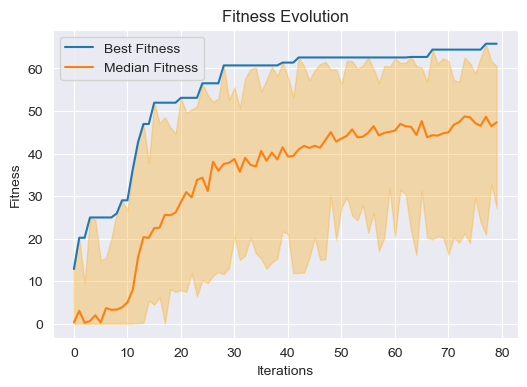

In [ ]:
fitness = np.array([[ant[1] for ant in trails] for trails in problem.trails_history])
best_fitness = np.array(problem.best_fitness_history)

fig, axs = plt.subplots(figsize=(6, 4))
axs.set_title('Fitness Evolution')
axs.set_xlabel('Iterations')
axs.set_ylabel('Fitness')

axs.plot(best_fitness, label='Best Fitness')

median = np.median(fitness, axis=1)
min_ = np.min(fitness, axis=1)
max_ = np.max(fitness, axis=1)

axs.plot(median, label='Median Fitness')
axs.fill_between(np.arange(len(median)), min_, max_, alpha=0.3, color='orange')

axs.legend()
plt.show()

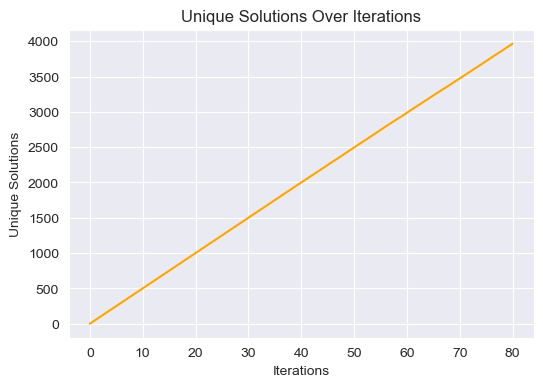

In [ ]:
from itertools import accumulate
from typing import List

# Population per iteration
population = np.array([[np.array(ant[0]) for ant in trails] for trails in problem.trails_history])

def stringify_individual(individual: List[int]) -> str:
    return ''.join([str(int(i)) for i in individual])

# Convert and accumulate unique sets
a = np.apply_along_axis(stringify_individual, 2, population)
a = list(accumulate(a, lambda x, y: x.union(set(y)), initial=set()))

fig, axs = plt.subplots(figsize=(6, 4))
axs.plot([len(x) for x in a], color='orange')
axs.set_title('Unique Solutions Over Iterations')
axs.set_xlabel('Iterations')
axs.set_ylabel('Unique Solutions')
plt.show()